## BIDS Dataset Loading Tutorial
Welcome! This notebook demonstrates how to interact with the Dyadic NIRS dataset in the BIDS format. We have created a helper tool (src/bids_loader) to simplify data loading.

There are 3 ways to access the data:

1. The Iterator: Loop through all the NIRS files.

2. Individual: Load a specific individual.

3. Dyadic: Load matched partners (Hyperscanning).

In [1]:
# Setup and Imports
import matplotlib.pyplot as plt
from src import config as cfg
from src import loaders, bids_loader

# Load Configuration
study_config = cfg.load_study_config()
bids_root = cfg.resolve_path(study_config["Paths"]["BidsRoot"])
task_name = study_config.get("TaskName", "drawing")

print(f"📂 Reading from: {bids_root.relative_to(cfg.PROJ_ROOT)}")

📂 Reading from: bids_dataset


## Level 1: The Iterator (All Data)
Use this pattern when you want to run a batch process (like filtering or artifact removal) on the entire dataset.

Note: We use a generator (yield), so it loads files one by one to save RAM.

In [2]:
NUM_FILES_TO_CHECK = None  # Set to None to process everyone


# Initialize the iterator
iterator = bids_loader.iter_dataset(bids_root, task_name)

print(f"🔄 Iterating through the first {NUM_FILES_TO_CHECK} files...")

# Loop through examples
for i, (sub, ses, raw) in enumerate(iterator):
    
    # Stop if we hit the limit
    if NUM_FILES_TO_CHECK and i >= NUM_FILES_TO_CHECK:
        print(f"... Limit reached ({NUM_FILES_TO_CHECK} files). Stopping demo.")
        break 
    
    # Check Metadata
    duration = raw.times[-1]
    print(raw)
    
    print(f"   ✅ Loaded sub-{sub} (ses-{ses}) | {duration:.1f}s")

🔄 Iterating through the first None files...
<RawSNIRF | sub-101_ses-02_task-drawing_acq-dyad1001_nirs.snirf, 52 x 8484 (1705.3 s), ~60 KiB, data not loaded>
   ✅ Loaded sub-101 (ses-02) | 1705.1s
<RawSNIRF | sub-103_ses-03_task-drawing_acq-dyad2001_nirs.snirf, 52 x 9132 (1835.5 s), ~60 KiB, data not loaded>
   ✅ Loaded sub-103 (ses-03) | 1835.3s
<RawSNIRF | sub-201_ses-02_task-drawing_acq-dyad1001_nirs.snirf, 52 x 5666 (1133.2 s), ~60 KiB, data not loaded>
   ✅ Loaded sub-201 (ses-02) | 1133.0s
<RawSNIRF | sub-301_ses-03_task-drawing_acq-dyad2001_nirs.snirf, 52 x 7674 (1450.4 s), ~64 KiB, data not loaded>
   ✅ Loaded sub-301 (ses-03) | 1450.2s


/Users/ahmedeldably/Downloads/Degrees/MSc/universities/ETH_Zurich/repos/Neuro-Struct/src/bids_loader.py:41: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2023-11-2214:19:51+01
  raw = read_raw_bids(target_file, verbose=False)
/Users/ahmedeldably/Downloads/Degrees/MSc/universities/ETH_Zurich/repos/Neuro-Struct/src/bids_loader.py:41: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2023-11-3014:47:41+01
  raw = read_raw_bids(target_file, verbose=False)
/Users/ahmedeldably/Downloads/Degrees/MSc/universities/ETH_Zurich/repos/Neuro-Struct/src/bids_loader.py:41: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2023-11-2214:29:20+01
  raw = read_raw_bids(target_file, verbose=False)


## Level 2: Individual Access
Use this when you want to inspect a specific subject. You need to set which subject and which session you want to investigate and plot.

🔍 Loading sub-101...
✅ Success! Found 52 channels.
Using matplotlib as 2D backend.


/Users/ahmedeldably/Downloads/Degrees/MSc/universities/ETH_Zurich/repos/Neuro-Struct/src/bids_loader.py:76: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2023-11-2214:19:51+01
  return read_raw_bids(matches[0], verbose=False)


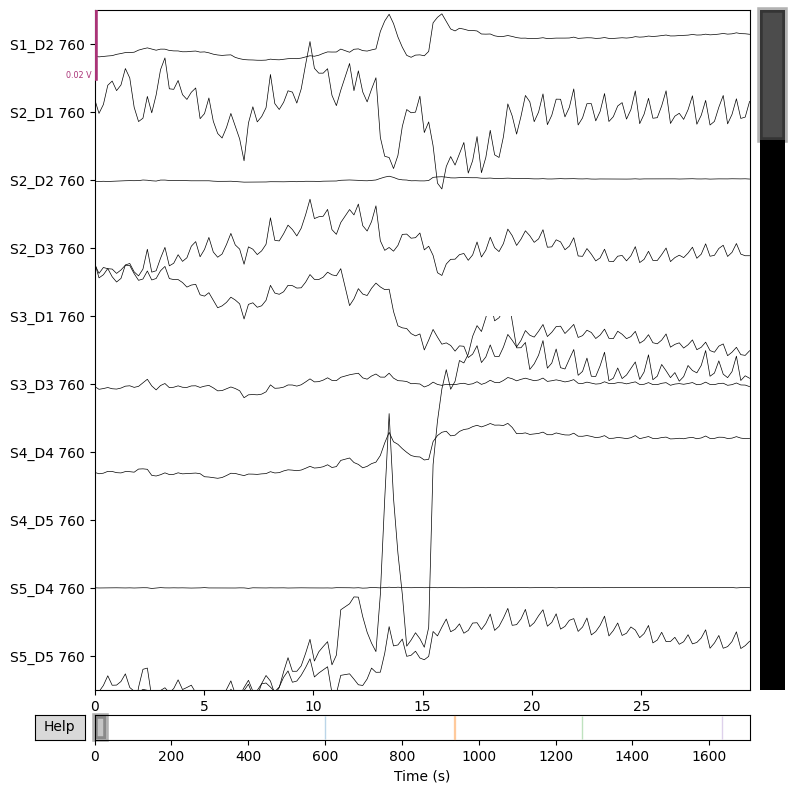

In [3]:
# Configuration
target_sub = "101"
target_ses = "02"

print(f"🔍 Loading sub-{target_sub}...")

# Load
raw = bids_loader.load_individual(bids_root, target_sub, target_ses, task_name)

if raw:
    print(f"✅ Success! Found {len(raw.ch_names)} channels.")
    
    # 📊 VISUALIZATION
    # We can plot the first few seconds to inspect signal quality
    raw.plot(n_channels=10, duration=30, scalings='auto', show=True);
else:
    print("❌ File not found.")

## Level 3: Dyadic Access (Hyperscanning)
Use this for synchrony analysis. This tool automatically looks up the dyadlist.csv, finds the partner, and ensures both files exist before giving them to you

👥 Requesting Dyad 1001...
✅ Pair Loaded Successfully!
   Time difference: 572.08 seconds

   📈 Plotting first 30 seconds overlay...


/Users/ahmedeldably/Downloads/Degrees/MSc/universities/ETH_Zurich/repos/Neuro-Struct/src/bids_loader.py:76: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2023-11-2214:19:51+01
  return read_raw_bids(matches[0], verbose=False)
/Users/ahmedeldably/Downloads/Degrees/MSc/universities/ETH_Zurich/repos/Neuro-Struct/src/bids_loader.py:76: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2023-11-2214:29:20+01
  return read_raw_bids(matches[0], verbose=False)


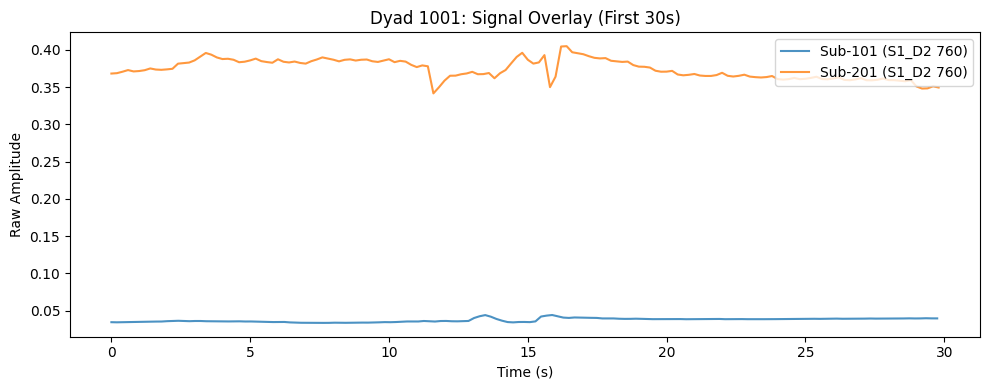

In [4]:
# 1. Load the Map once (acts as your database)
dyad_map = loaders.load_dyad_grouping(cfg.DYAD_FILE)

# Pick an example ID to visualize
demo_dyad_id = "1001"
ses_id = "02"

print(f"👥 Requesting Dyad {demo_dyad_id}...")

# 2. Load the Pair
pair_data = bids_loader.load_dyad_pair(
    bids_root, 
    dyad_id=demo_dyad_id,     # Just ask for the ID
    grouping_map=dyad_map,    # Pass the map
    ses_id=ses_id, 
    task_name=task_name
)

if pair_data:
    raw_a, raw_b = pair_data
    print(f"✅ Pair Loaded Successfully!")
    
    # Quick sanity check: Do they have matching recording lengths?
    diff = abs(raw_a.times[-1] - raw_b.times[-1])
    print(f"   Time difference: {diff:.2f} seconds")

    # VISUALIZATION: HYPERSCANNING CHECK
    print("\n   📈 Plotting first 30 seconds overlay...")
    
    # Retrieve subject IDs for the legend
    subjects = dyad_map[demo_dyad_id]
    
    # Pick the first channel dynamically
    ch_idx = 0
    ch_name_a = raw_a.ch_names[ch_idx]
    ch_name_b = raw_b.ch_names[ch_idx]
    
    # Extract 30 seconds of data
    start, stop = 0, 30
    data_a, times_a = raw_a.get_data(picks=ch_idx, tmin=start, tmax=stop, return_times=True)
    data_b, times_b = raw_b.get_data(picks=ch_idx, tmin=start, tmax=stop, return_times=True)

    # Plot the raw signal
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(times_a, data_a.T, label=f"Sub-{subjects[0]} ({ch_name_a})", color='tab:blue', alpha=0.8)
    ax.plot(times_b, data_b.T, label=f"Sub-{subjects[1]} ({ch_name_b})", color='tab:orange', alpha=0.8)
    
    ax.set_title(f"Dyad {demo_dyad_id}: Signal Overlay (First 30s)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Raw Amplitude")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Could not load pair (check if session exists for both).")

## Level 4: All Dyads (Batch Processing)
Use this pattern when you want to calculate metrics (like Coherence or Pearson Correlation) for every single dyad in the study automatically.

In [11]:
# Initialize the Generator

MAX_NUMBER_OF_DYADS = 1
dyad_iterator = bids_loader.iter_dyads(bids_root, dyad_map, task_name)

# Loop through pairs
for i, (dyad_id, ses, raw_a, raw_b) in enumerate(dyad_iterator):
    # Stop if we hit the limit
    if MAX_NUMBER_OF_DYADS and i >= MAX_NUMBER_OF_DYADS:
        print(f"... Limit reached ({MAX_NUMBER_OF_DYADS} dyads). Stopping demo.")
        break 
    
    
    # Get subject names directly from our map
    subjects = dyad_map[dyad_id]
    sub_a_id = subjects[0]
    sub_b_id = subjects[1]
    
    print(f"   ✅ Processed Dyad {dyad_id} (ses-{ses})")
    print(f"      Sub-{sub_a_id} vs Sub-{sub_b_id}")
    print(f"      Shared Duration: {min(raw_a.times[-1], raw_b.times[-1]):.1f}s")
    print("")

print("🎉 Batch processing demo complete.")

   ✅ Processed Dyad 1001 (ses-02)
      Sub-101 vs Sub-201
      Shared Duration: 1133.0s

🎉 Batch processing demo complete.


/Users/ahmedeldably/Downloads/Degrees/MSc/universities/ETH_Zurich/repos/Neuro-Struct/src/bids_loader.py:76: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2023-11-2214:19:51+01
  return read_raw_bids(matches[0], verbose=False)
/Users/ahmedeldably/Downloads/Degrees/MSc/universities/ETH_Zurich/repos/Neuro-Struct/src/bids_loader.py:76: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2023-11-2214:29:20+01
  return read_raw_bids(matches[0], verbose=False)
/Users/ahmedeldably/Downloads/Degrees/MSc/universities/ETH_Zurich/repos/Neuro-Struct/src/bids_loader.py:76: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2023-11-3014:47:41+01
  return read_raw_bids(matches[0], verbose=False)
